#### Scripts modified from
https://jeremymsimon.github.io/chromap_vs_cellranger_scATAC_exploration_10x/ComparisonPart1.html

In [4]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(Signac))
suppressPackageStartupMessages(library(ggsankey))
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(ggpubr))

### PBMC

#### Loading data

In [2]:
piscem_data_dir <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fastqs/k25_m_17/bin-size=1000_thr=0.7_orp=false"
chromap_data_dir <- "/fs/cbcb-lab/rob/students/noor/Atacseq/chromap_output/map_output/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fastqs"
cellranger_data_dir <- "/fs/cbcb-lab/rob/students/noor/Atacseq/cell_ranger_output/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fastqs"
env <- new.env()
load(file.path(piscem_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
piscem_ob <- env$seurat_ob_sub
load(file.path(chromap_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
chromap_ob <- env$seurat_ob_sub
load(file.path(cellranger_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
cellranger_macs2_ob <- env$seurat_ob_sub
load(file.path(cellranger_data_dir, "10k_pbmc.rdata"), envir = env)
cellranger_ob <- env$seurat_ob_sub

#### Extracting Clusters

In [3]:
clust_piscem <- piscem_ob$seurat_clusters
clust_chromap <- chromap_ob$seurat_clusters
clust_cellranger <- cellranger_ob$seurat_clusters
clust_cellranger_macs2 <- cellranger_macs2_ob$seurat_clusters
print(length(clust_piscem))
print(length(clust_chromap))
print(length(clust_cellranger))
print(length(clust_cellranger_macs2))

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Signac



[1] 10394
[1] 10408
[1] 10234
[1] 10411


In [6]:
clust_piscem_tbl <- 
    enframe(clust_piscem) %>% 
    dplyr::rename("Barcode" = name, "Piscem_Cluster" = value) %>%
    mutate(Piscem_Cluster = as.numeric(as.character(Piscem_Cluster))) %>%
    separate(Barcode,into = paste0("V", c(1:9)), sep="_") %>%
    mutate(Barcode=V9) %>%
    select(Barcode, Piscem_Cluster)

clust_chromap_tbl <- enframe(clust_chromap) %>% 
    dplyr::rename("Barcode" = name, "Chromap_Cluster" = value) %>%
    mutate(Chromap_Cluster = as.numeric(as.character(Chromap_Cluster)))  %>%
    separate(Barcode,into = paste0("V", c(1:9)), sep="_") %>%
    mutate(Barcode=V9) %>%
#     select(Barcode, Chromap_Cluster)
#     mutate(RC = stringi::stri_reverse(chartr(old="ATGC", new="TACG", Barcode))) %>%
#     mutate(temp = RC) %>%
#     mutate(RC = Barcode, Barcode = temp) %>%
    select(Barcode, Chromap_Cluster)

clust_cellranger_macs2_tbl <- enframe(clust_cellranger_macs2) %>% 
    dplyr::rename("Barcode" = name, "CellRanger_Cluster" = value) %>%
    mutate(CellRanger_Cluster = as.numeric(as.character(CellRanger_Cluster)))  %>%
    separate(Barcode,into = paste0("V", c(1:10)), sep="_") %>%
    mutate(Barcode=V10) %>%
    mutate(Barcode = str_replace_all(Barcode,"-1$","")) %>%
#     select(Barcode, Chromap_Cluster)
#     mutate(RC = stringi::stri_reverse(chartr(old="ATGC", new="TACG", Barcode))) %>%
#     mutate(temp = RC) %>%
#     mutate(RC = Barcode, Barcode = temp) %>%
    select(Barcode, CellRanger_Cluster)

clust_cellranger_tbl <- enframe(clust_cellranger) %>%
    dplyr::rename("Barcode" = name, "CellRanger_Cluster" = value) %>%
        mutate(CellRanger_Cluster = as.numeric(as.character(CellRanger_Cluster))) %>%
        mutate(Barcode = str_replace_all(Barcode,"-1$",""))

#### Sankey plot

##### Chromap vs Piscem

In [14]:
size <- 22
fs <- 5
pChA <- make_long (
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode"),
    Chromap_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("Chromap_Cluster","Piscem_Cluster"),labels = c("Chromap","alevin-fry-atac"))

##### Piscem vs Cell Ranger

In [15]:
pCrA <- make_long (
    full_join(clust_cellranger_tbl,clust_piscem_tbl,by="Barcode"),
    CellRanger_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("CellRanger_Cluster","Piscem_Cluster"),labels = c("Cell Ranger ATAC","alevin-fry-atac"))

In [16]:
pCrmA <- make_long (
    full_join(clust_cellranger_macs2_tbl,clust_piscem_tbl,by="Barcode"),
    CellRanger_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("CellRanger_Cluster","Piscem_Cluster"),labels = c("Cell Ranger ATAC","alevin-fry-atac"))

##### Chromap vs Cell Ranger

In [17]:
pCrCh <- make_long (
    full_join(clust_cellranger_tbl,clust_chromap_tbl,by="Barcode"),
    CellRanger_Cluster, Chromap_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("CellRanger_Cluster","Chromap_Cluster"),labels = c("Cell Ranger ATAC","Chromap"))

In [18]:
pCrmCh <- make_long (
    full_join(clust_cellranger_macs2_tbl,clust_chromap_tbl,by="Barcode"),
    CellRanger_Cluster, Chromap_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("CellRanger_Cluster","Chromap_Cluster"),labels = c("Cell Ranger ATAC","Chromap"))

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”


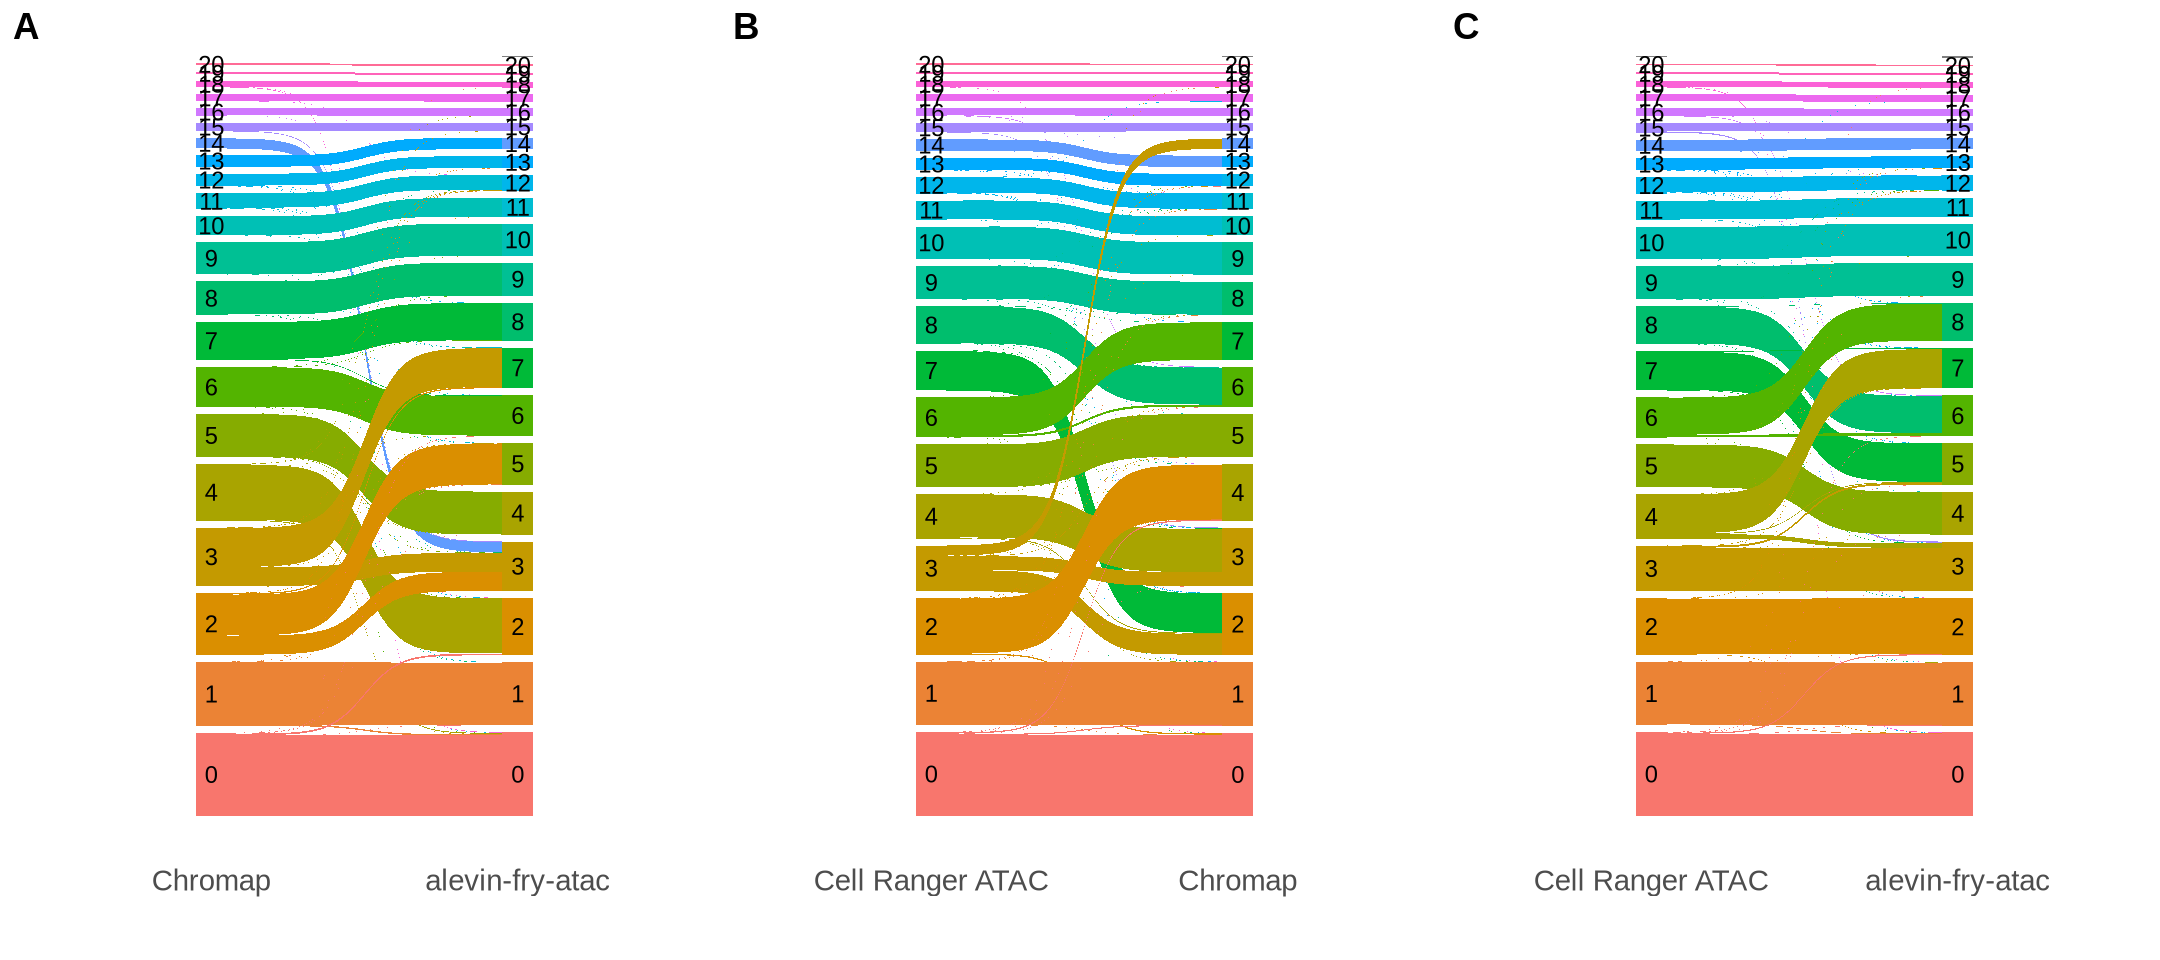

In [19]:
options(repr.plot.width=18, repr.plot.height=8)
ggarrange(pChA, pCrmCh, pCrmA, nrow = 1, labels = c("A", "B", "C"), font.label = list(size=size))
# ggarrange(pCrCh, pCrA, nrow = 1)

#### UMAP

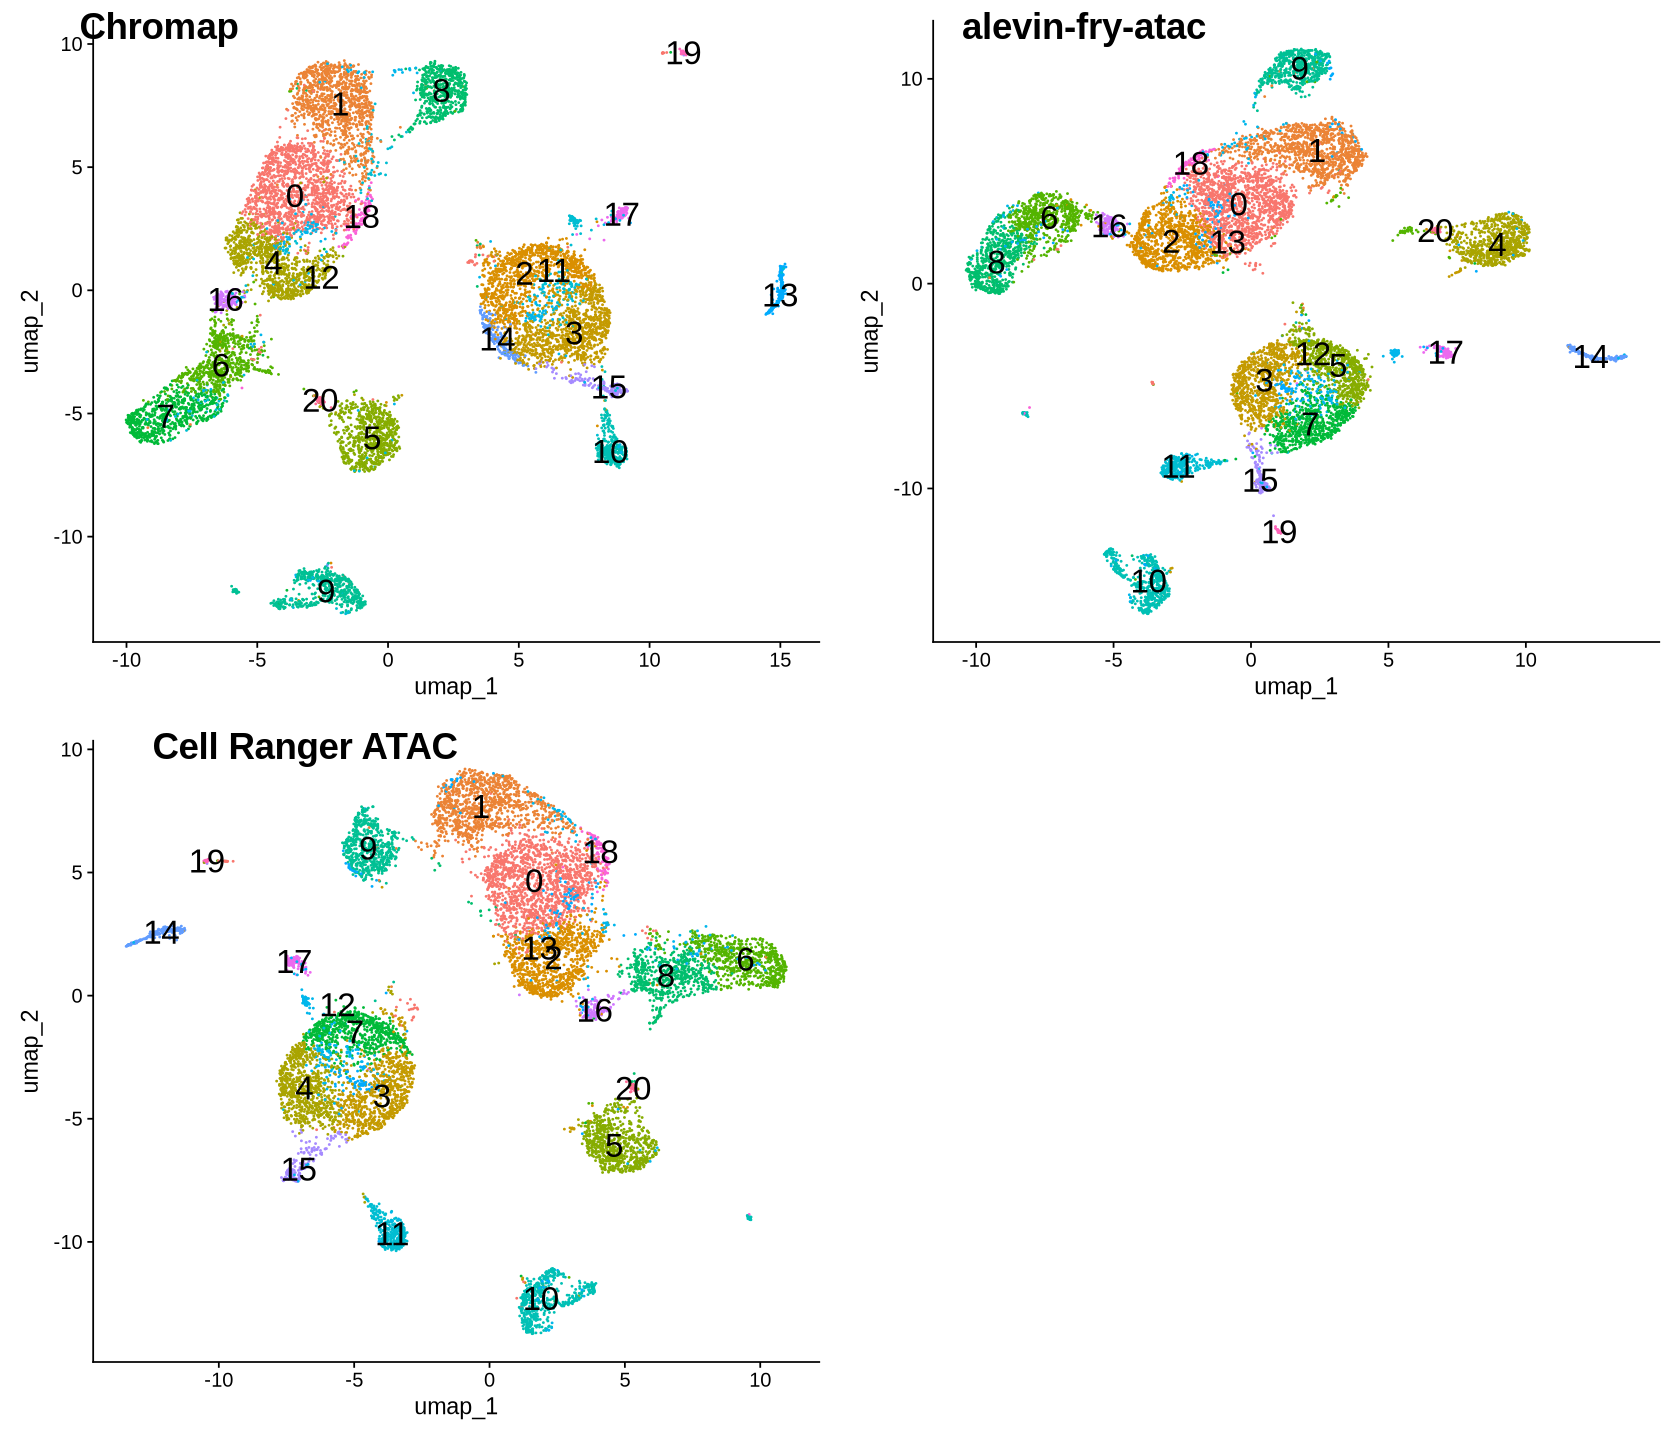

In [20]:
options(repr.plot.width=14, repr.plot.height=12)
pCh <- DimPlot(object = chromap_ob, label = TRUE, label.size = 7) + NoLegend()
pA <- DimPlot(object = piscem_ob, label = TRUE, label.size = 7) + NoLegend()
pCr <- DimPlot(object = cellranger_ob, label = TRUE, label.size = 7) + NoLegend()
pCrm <- DimPlot(object = cellranger_macs2_ob, label = TRUE, label.size = 7) + NoLegend()
ggarrange(pCh, pA, pCrm, labels = c("Chromap", "alevin-fry-atac", "Cell Ranger ATAC"), font.label = list(size=size))

#### Cluster comparisons

##### Piscem vs Chromap

In [81]:
int_cells <- intersect(clust_chromap_tbl$Barcode, clust_piscem_tbl$Barcode)
length(int_cells)
clust_chromap_tt <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tt <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_chromap_tt,clust_piscem_tt,by="Barcode")

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 10391

[1] 0.8662917

[1] 0.9125303

##### Piscem vs CellRanger

In [82]:
int_cells <- intersect(clust_cellranger_tbl$Barcode, clust_piscem_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tt <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_cellranger_tt,clust_piscem_tt,by="Barcode")

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Piscem_Cluster)

[1] 10233

[1] 0.7342683

[1] 0.8090178

In [83]:
int_cells <- intersect(clust_cellranger_macs2_tbl$Barcode, clust_piscem_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_macs2_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tt <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_cellranger_tt,clust_piscem_tt,by="Barcode")

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Piscem_Cluster)

[1] 10389

[1] 0.9331702

[1] 0.9394632

##### Chromap vs CellRanger

In [84]:
int_cells <- intersect(clust_cellranger_tbl$Barcode, clust_chromap_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_tbl %>%
    filter(Barcode %in% int_cells)
clust_chromap_tt <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_chromap_tt,clust_cellranger_tt,by="Barcode")

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Chromap_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Chromap_Cluster)

[1] 10234

[1] 0.708681

[1] 0.8073469

In [ ]:
int_cells <- intersect(clust_cellranger_macs2_tbl$Barcode, clust_chromap_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_macs2_tbl %>%
    filter(Barcode %in% int_cells)
clust_chromap_tt <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_chromap_tt,clust_cellranger_tt,by="Barcode")

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Chromap_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Chromap_Cluster)

##### All together

In [85]:
int_cells <- intersect(intersect(clust_cellranger_tbl$Barcode, clust_chromap_tbl$Barcode), clust_piscem_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_tbl %>%
    filter(Barcode %in% int_cells)
clust_chromap_tt <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tt <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(full_join(clust_chromap_tt,clust_cellranger_tt, by="Barcode"), clust_piscem_tt, by="Barcode")

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Chromap_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Chromap_Cluster)

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Piscem_Cluster)

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 10233

[1] 0.7088061

[1] 0.8074872

[1] 0.7342683

[1] 0.8090178

[1] 0.8655199

[1] 0.9118279

In [86]:
int_cells <- intersect(intersect(clust_cellranger_macs2_tbl$Barcode, clust_chromap_tbl$Barcode), clust_piscem_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_macs2_tbl %>%
    filter(Barcode %in% int_cells)
clust_chromap_tt <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tt <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(full_join(clust_chromap_tt,clust_cellranger_tt, by="Barcode"), clust_piscem_tt, by="Barcode")

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Chromap_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Chromap_Cluster)

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Piscem_Cluster)

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 10389

[1] 0.8721204

[1] 0.9110856

[1] 0.9331702

[1] 0.9394632

[1] 0.8662799

[1] 0.9125108

#### Extract peaks

In [87]:
chromapPeaks <- read.table(file.path(chromap_data_dir, "macs2_peaks.narrowPeak"))
chromapPeaks <- chromapPeaks[,c(1:3)]
colnames(chromapPeaks) <- c("chr","start","end")
chromapPeaksGr <- makeGRangesFromDataFrame(chromapPeaks)
chromapPeaksGr <- keepStandardChromosomes(chromapPeaksGr, pruning.mode="coarse")

piscemPeaks <- read.table(file.path(piscem_data_dir, "macs2_peaks.narrowPeak"))
piscemPeaks <- piscemPeaks[,c(1:3)]
colnames(piscemPeaks) <- c("chr","start","end")
piscemPeaksGr <- makeGRangesFromDataFrame(piscemPeaks)
piscemPeaksGr <- keepStandardChromosomes(piscemPeaksGr, pruning.mode="coarse")

cellRangerPeaks <- read.table(file.path(cellranger_data_dir, "10k_pbmc_peaks.bed"))
cellRangerPeaks <- cellRangerPeaks[,c(1:3)]
colnames(cellRangerPeaks) <- c("chr","start","end")
cellRangerPeaksGr <- makeGRangesFromDataFrame(cellRangerPeaks)
cellRangerPeaksGr <- keepStandardChromosomes(cellRangerPeaksGr, pruning.mode="coarse")

cellRangerMacs2Peaks <- read.table(file.path(cellranger_data_dir, "macs2_peaks.narrowPeak"))
cellRangerMacs2Peaks <- cellRangerMacs2Peaks[,c(1:3)]
colnames(cellRangerMacs2Peaks) <- c("chr","start","end")
cellRangerMacs2PeaksGr <- makeGRangesFromDataFrame(cellRangerMacs2Peaks)
cellRangerMacs2PeaksGr <- keepStandardChromosomes(cellRangerMacs2PeaksGr, pruning.mode="coarse")

In [88]:
summary(width(chromapPeaksGr))
summary(width(piscemPeaksGr))
summary(width(cellRangerPeaksGr))
summary(width(cellRangerMacs2PeaksGr))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  156.0   322.0   547.0   645.7   853.0  4605.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  155.0   318.0   540.0   642.6   849.0  4613.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  209.0   826.0   877.0   847.6   902.0  2036.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  156.0   321.0   546.0   645.5   853.0  5080.0 

In [89]:
length(chromapPeaksGr)
sum(width(chromapPeaksGr))/1e6
length(piscemPeaksGr)
sum(width(piscemPeaksGr))/1e6
length(cellRangerPeaksGr)
sum(width(cellRangerPeaksGr))/1e6
length(cellRangerMacs2PeaksGr)
sum(width(cellRangerMacs2PeaksGr))/1e6

[1] 150877

[1] 97.42325

[1] 153032

[1] 98.33215

[1] 165376

[1] 140.175

[1] 152748

[1] 98.59533

##### Piscem vs Chromap

In [90]:
common <- intersect_ranges(piscemPeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)
length(join_overlap_inner(chromapPeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 147816

[1] 94.5306

[1] 0.979712

[1] 0.9659156

##### CellRanger vs Chromap

In [91]:
common <- intersect_ranges(cellRangerPeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(chromapPeaksGr, cellRangerPeaksGr)) / length(cellRangerPeaksGr)
length(join_overlap_inner(cellRangerPeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)

[1] 130902

[1] 75.56667

[1] 0.7915477

[1] 0.867614

In [92]:
common <- intersect_ranges(cellRangerMacs2PeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(chromapPeaksGr, cellRangerMacs2PeaksGr)) / length(cellRangerMacs2PeaksGr)
length(join_overlap_inner(cellRangerMacs2PeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)

[1] 149578

[1] 96.12084

[1] 0.9792469

[1] 0.9913903

##### CellRanger vs Piscem

In [93]:
common <- intersect_ranges(cellRangerPeaksGr, piscemPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, cellRangerPeaksGr)) / length(cellRangerPeaksGr)
length(join_overlap_inner(cellRangerPeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 131529

[1] 75.71258

[1] 0.7953452

[1] 0.8595

In [94]:
common <- intersect_ranges(cellRangerMacs2PeaksGr, piscemPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, cellRangerMacs2PeaksGr)) / length(cellRangerMacs2PeaksGr)
length(join_overlap_inner(cellRangerMacs2PeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 148203

[1] 94.6581

[1] 0.9702451

[1] 0.9684445

### 8K Mouse Cortex

#### Loading data

In [1]:
piscem_data_dir <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_fastqs/k25_m_17/bin-size=1000_thr=0.7_orp=false"
chromap_data_dir <- "/fs/cbcb-lab/rob/students/noor/Atacseq/chromap_output/map_output/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_fastqs"
cellranger_data_dir <- "/fs/cbcb-lab/rob/students/noor/Atacseq/cell_ranger_output/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_fastqs"
env <- new.env()
load(file.path(piscem_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
piscem_ob <- env$seurat_ob_sub
load(file.path(chromap_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
chromap_ob <- env$seurat_ob_sub
load(file.path(cellranger_data_dir, "8k_cortex.rdata"), envir = env)
cellranger_ob <- env$seurat_ob_sub
load(file.path(cellranger_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
cellranger_macs2_ob <- env$seurat_ob_sub

#### Extracting clusters

In [2]:
clust_piscem <- piscem_ob$seurat_clusters
clust_chromap <- chromap_ob$seurat_clusters
clust_cellranger <- cellranger_ob$seurat_clusters
clust_cellranger_macs2 <- cellranger_macs2_ob$seurat_clusters
print(length(clust_piscem))
print(length(clust_chromap))
print(length(clust_cellranger))
print(length(clust_cellranger_macs2))

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Signac



[1] 7748
[1] 7774
[1] 7594
[1] 7784


In [5]:
clust_piscem_tbl <- 
    enframe(clust_piscem) %>% 
    dplyr::rename("Barcode" = name, "Piscem_Cluster" = value) %>%
    mutate(Piscem_Cluster = as.numeric(as.character(Piscem_Cluster))) %>%
    separate(Barcode,into = paste0("V", c(1:10)), sep="_") %>%
    mutate(Barcode=V10) %>%
    select(Barcode, Piscem_Cluster)

clust_chromap_tbl <- enframe(clust_chromap) %>% 
    dplyr::rename("Barcode" = name, "Chromap_Cluster" = value) %>%
    mutate(Chromap_Cluster = as.numeric(as.character(Chromap_Cluster)))  %>%
    separate(Barcode,into = paste0("V", c(1:10)), sep="_") %>%
    mutate(Barcode=V10) %>%
#     select(Barcode, Chromap_Cluster)
#     mutate(RC = stringi::stri_reverse(chartr(old="ATGC", new="TACG", Barcode))) %>%
#     mutate(temp = RC) %>%
#     mutate(RC = Barcode, Barcode = temp) %>%
    select(Barcode, Chromap_Cluster)

clust_cellranger_tbl <- enframe(clust_cellranger) %>%
    dplyr::rename("Barcode" = name, "CellRanger_Cluster" = value) %>%
        mutate(CellRanger_Cluster = as.numeric(as.character(CellRanger_Cluster))) %>%
        mutate(Barcode = str_replace_all(Barcode,"-1$",""))

clust_cellranger_macs2_tbl <- 
    enframe(clust_cellranger_macs2) %>% 
    dplyr::rename("Barcode" = name, "CellRanger_Cluster" = value) %>%
    mutate(CellRanger_Cluster = as.numeric(as.character(CellRanger_Cluster))) %>%
    separate(Barcode,into = paste0("V", c(1:11)), sep="_") %>%
    mutate(Barcode=V11) %>%
    mutate(Barcode = str_replace_all(Barcode,"-1$","")) %>%
    select(Barcode, CellRanger_Cluster)

#### Sankey Plot

##### Chromap vs Piscem

In [6]:
size <- 22
fs <- 5
pChA <- make_long (
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode"),
    Chromap_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("Chromap_Cluster","Piscem_Cluster"),labels = c("Chromap","alevin-fry-atac"))

##### CellRanger vs Piscem

In [7]:
pCrA <- make_long (
    full_join(clust_cellranger_tbl,clust_piscem_tbl,by="Barcode"),
    CellRanger_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("CellRanger_Cluster","Piscem_Cluster"),labels = c("Cell Ranger ATAC","alevin-fry-atac"))

In [8]:
pCrmA <- make_long (
    full_join(clust_cellranger_macs2_tbl,clust_piscem_tbl,by="Barcode"),
    CellRanger_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("CellRanger_Cluster","Piscem_Cluster"),labels = c("Cell Ranger ATAC","alevin-fry-atac"))

##### Chromap vs Cell Ranger

In [9]:
pCrCh <- make_long (
    full_join(clust_cellranger_tbl,clust_chromap_tbl,by="Barcode"),
    CellRanger_Cluster, Chromap_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("CellRanger_Cluster","Chromap_Cluster"),labels = c("Cell Ranger ATAC","Chromap"))

In [10]:
pCrmCh <- make_long (
    full_join(clust_cellranger_macs2_tbl,clust_chromap_tbl,by="Barcode"),
    CellRanger_Cluster, Chromap_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("CellRanger_Cluster","Chromap_Cluster"),labels = c("Cell Ranger ATAC","Chromap"))

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”


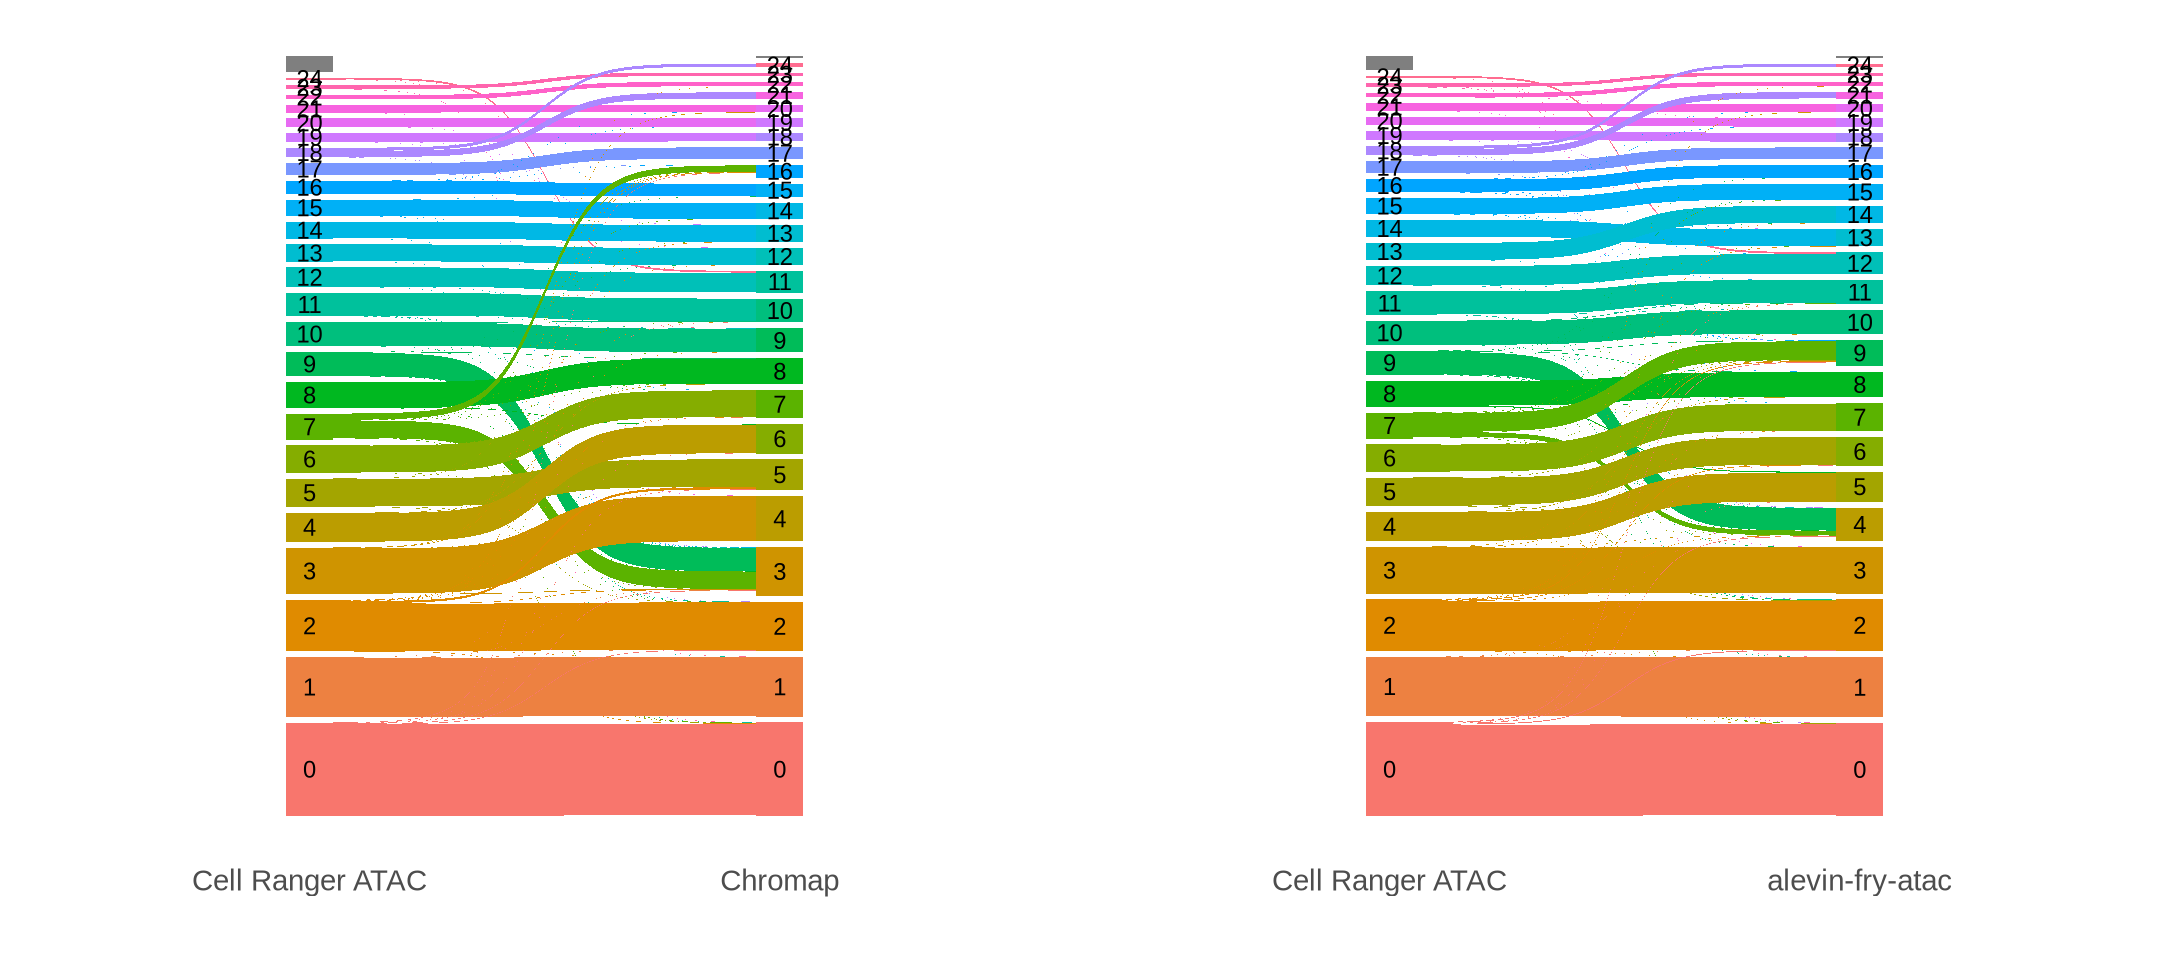

In [11]:
options(repr.plot.width=18, repr.plot.height=8)
p8k <- ggarrange(pChA, pCrmCh, pCrmA, nrow = 1)
ggarrange(pCrCh, pCrA, nrow = 1)

#### UMAP

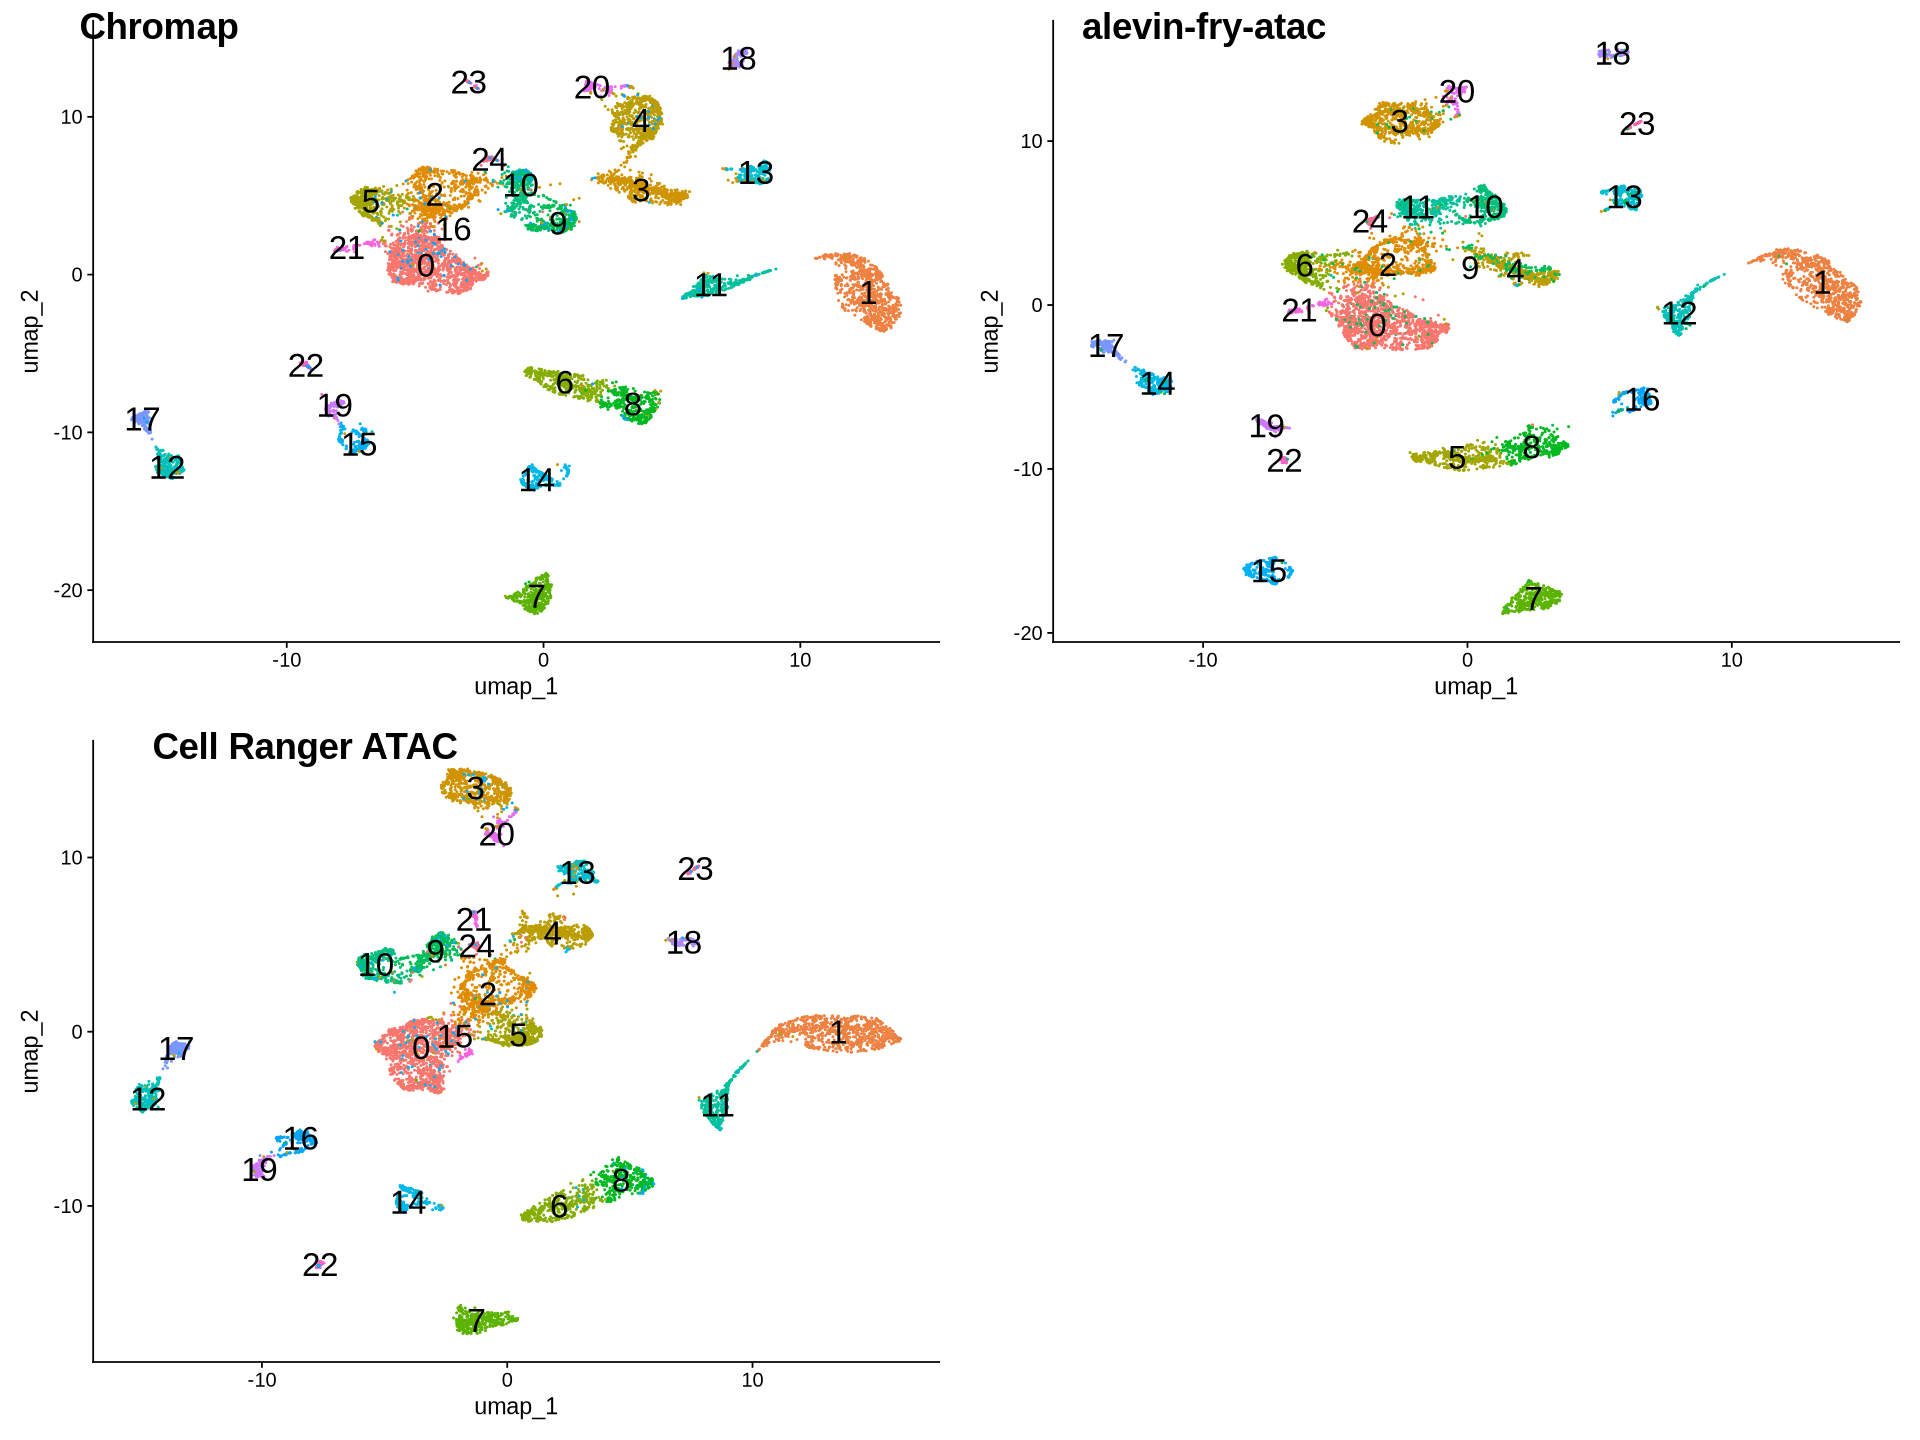

In [12]:
options(repr.plot.width=16, repr.plot.height=12)
pCh <- DimPlot(object = chromap_ob, label = TRUE, label.size = 7) + NoLegend()
pA <- DimPlot(object = piscem_ob, label = TRUE, label.size = 7) + NoLegend()
pCr <- DimPlot(object = cellranger_ob, label = TRUE, label.size = 7) + NoLegend()
pCrm <- DimPlot(object = cellranger_macs2_ob, label = TRUE, label.size = 7) + NoLegend()
ggarrange(pCh, pA, pCrm, labels = c("Chromap", "alevin-fry-atac", "Cell Ranger ATAC"), font.label = list(size=size))

#### Cluster comparisons

##### Piscem vs Chromap

In [13]:
int_cells <- intersect(clust_chromap_tbl$Barcode, clust_piscem_tbl$Barcode)
length(int_cells)
clust_chromap_tbl <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tbl <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode")

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 7746

[1] 0.9432878

[1] 0.9557816

##### Piscem vs CellRanger

In [56]:
int_cells <- intersect(clust_cellranger_tbl$Barcode, clust_piscem_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tt <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_cellranger_tt,clust_piscem_tt,by="Barcode")

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Piscem_Cluster)

[1] 7576

[1] 0.941645

[1] 0.940779

##### CellRanger vs Chromap

In [57]:
int_cells <- intersect(clust_cellranger_tbl$Barcode, clust_chromap_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_tbl %>%
    filter(Barcode %in% int_cells)
clust_chromap_tt <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_chromap_tt,clust_cellranger_tt,by="Barcode")

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Chromap_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Chromap_Cluster)

[1] 7577

[1] 0.9285877

[1] 0.9368604

In [55]:
int_cells <- intersect(intersect(clust_cellranger_tbl$Barcode, clust_chromap_tbl$Barcode), clust_piscem_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_tbl %>%
    filter(Barcode %in% int_cells)
clust_chromap_tt <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tt <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(full_join(clust_chromap_tt,clust_cellranger_tt, by="Barcode"), clust_piscem_tt, by="Barcode")
mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Chromap_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Chromap_Cluster)

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Piscem_Cluster)

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 7575

[1] 0.9287843

[1] 0.9369246

[1] 0.9417872

[1] 0.9408442

[1] 0.9474066

[1] 0.9563914

In [56]:
int_cells <- intersect(intersect(clust_cellranger_macs2_tbl$Barcode, clust_chromap_tbl$Barcode), clust_piscem_tbl$Barcode)
length(int_cells)
clust_cellranger_tt <- clust_cellranger_macs2_tbl %>%
    filter(Barcode %in% int_cells)
clust_chromap_tt <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tt <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(full_join(clust_chromap_tt,clust_cellranger_tt, by="Barcode"), clust_piscem_tt, by="Barcode")
mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Chromap_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Chromap_Cluster)

mclust::adjustedRandIndex(joined$CellRanger_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$CellRanger_Cluster, joined$Piscem_Cluster)

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 7743

[1] 0.9617093

[1] 0.9646531

[1] 0.9338826

[1] 0.9481406

[1] 0.9434184

[1] 0.9557659

#### Extract peaks

In [57]:
chromapPeaks <- read.table(file.path(chromap_data_dir, "macs2_peaks.narrowPeak"))
chromapPeaks <- chromapPeaks[,c(1:3)]
colnames(chromapPeaks) <- c("chr","start","end")
chromapPeaksGr <- makeGRangesFromDataFrame(chromapPeaks)
chromapPeaksGr <- keepStandardChromosomes(chromapPeaksGr, pruning.mode="coarse")

piscemPeaks <- read.table(file.path(piscem_data_dir, "macs2_peaks.narrowPeak"))
piscemPeaks <- piscemPeaks[,c(1:3)]
colnames(piscemPeaks) <- c("chr","start","end")
piscemPeaksGr <- makeGRangesFromDataFrame(piscemPeaks)
piscemPeaksGr <- keepStandardChromosomes(piscemPeaksGr, pruning.mode="coarse")

cellRangerPeaks <- read.table(file.path(cellranger_data_dir, "8k_cortex_peaks.bed"))
cellRangerPeaks <- cellRangerPeaks[,c(1:3)]
colnames(cellRangerPeaks) <- c("chr","start","end")
cellRangerPeaksGr <- makeGRangesFromDataFrame(cellRangerPeaks)
cellRangerPeaksGr <- keepStandardChromosomes(cellRangerPeaksGr, pruning.mode="coarse")

cellRangerMacs2Peaks <- read.table(file.path(cellranger_data_dir, "macs2_peaks.narrowPeak"))
cellRangerMacs2Peaks <- cellRangerMacs2Peaks[,c(1:3)]
colnames(cellRangerMacs2Peaks) <- c("chr","start","end")
cellRangerMacs2PeaksGr <- makeGRangesFromDataFrame(cellRangerMacs2Peaks)
cellRangerMacs2PeaksGr <- keepStandardChromosomes(cellRangerMacs2PeaksGr, pruning.mode="coarse")

In [58]:
summary(width(chromapPeaksGr))
summary(width(piscemPeaksGr))
summary(width(cellRangerPeaksGr))
summary(width(cellRangerMacs2PeaksGr))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  164.0   330.0   547.0   655.1   864.0 29855.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  163.0   327.0   541.0   650.3   857.0 10746.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  130.0   833.0   879.0   853.8   904.0  1877.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  170.0   336.0   553.0   654.1   861.0  4124.0 

In [59]:
length(chromapPeaksGr)
sum(width(chromapPeaksGr))/1e6
length(piscemPeaksGr)
sum(width(piscemPeaksGr))/1e6
length(cellRangerPeaksGr)
sum(width(cellRangerPeaksGr))/1e6
length(cellRangerMacs2PeaksGr)
sum(width(cellRangerMacs2PeaksGr))/1e6

[1] 165336

[1] 108.3156

[1] 165874

[1] 107.8645

[1] 176609

[1] 150.7972

[1] 171518

[1] 112.1837

##### Piscem vs Chromap

In [60]:
common <- intersect_ranges(piscemPeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)
length(join_overlap_inner(chromapPeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 162535

[1] 105.2943

[1] 0.9830587

[1] 0.9798703

##### CellRanger vs Chromap

In [62]:
common <- intersect_ranges(cellRangerPeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(chromapPeaksGr, cellRangerPeaksGr)) / length(cellRangerPeaksGr)
length(join_overlap_inner(cellRangerPeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)

[1] 147314

[1] 84.17544

[1] 0.8341251

[1] 0.8909977

In [61]:
common <- intersect_ranges(cellRangerMacs2PeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(chromapPeaksGr, cellRangerMacs2PeaksGr)) / length(cellRangerMacs2PeaksGr)
length(join_overlap_inner(cellRangerMacs2PeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)

[1] 162633

[1] 105.599

[1] 0.9481979

[1] 0.9836515

##### CellRanger vs Piscem

In [63]:
common <- intersect_ranges(cellRangerPeaksGr, piscemPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, cellRangerPeaksGr)) / length(cellRangerPeaksGr)
length(join_overlap_inner(cellRangerPeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 147258

[1] 83.75727

[1] 0.833808

[1] 0.8877702

In [62]:
common <- intersect_ranges(cellRangerMacs2PeaksGr, piscemPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, cellRangerMacs2PeaksGr)) / length(cellRangerMacs2PeaksGr)
length(join_overlap_inner(cellRangerMacs2PeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 161822

[1] 104.4057

[1] 0.9434695

[1] 0.9755718

#### Human Brain 3K

#### Loading data

In [14]:
piscem_data_dir <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/human_brain_3k_fastqs/k25_m_17/bin-size=1000_thr=0.7_orp=false"
chromap_data_dir <- "/fs/cbcb-lab/rob/students/noor/Atacseq/chromap_output/map_output/human_brain_3k_fastqs"
env <- new.env()
load(file.path(piscem_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
piscem_ob <- env$seurat_ob_sub
load(file.path(chromap_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
chromap_ob <- env$seurat_ob_sub

#### Extracting clusters

In [15]:
clust_piscem <- piscem_ob$seurat_clusters
clust_chromap <- chromap_ob$seurat_clusters
print(length(clust_piscem))
print(length(clust_chromap))

[1] 3453
[1] 3449


In [16]:
clust_piscem_tbl <- 
    enframe(clust_piscem) %>% 
    dplyr::rename("Barcode" = name, "Piscem_Cluster" = value) %>%
    mutate(Piscem_Cluster = as.numeric(as.character(Piscem_Cluster))) %>%
    separate(Barcode,into = paste0("V", c(1:6)), sep="_") %>%
    mutate(Barcode=V6) %>%
    select(Barcode, Piscem_Cluster)

clust_chromap_tbl <- enframe(clust_chromap) %>% 
    dplyr::rename("Barcode" = name, "Chromap_Cluster" = value) %>%
    mutate(Chromap_Cluster = as.numeric(as.character(Chromap_Cluster)))  %>%
    separate(Barcode,into = paste0("V", c(1:6)), sep="_") %>%
    mutate(Barcode=V6) %>%
#     select(Barcode, Chromap_Cluster)
#     mutate(RC = stringi::stri_reverse(chartr(old="ATGC", new="TACG", Barcode))) %>%
#     mutate(temp = RC) %>%
#     mutate(RC = Barcode, Barcode = temp) %>%
    select(Barcode, Chromap_Cluster)

#### Sankey plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”


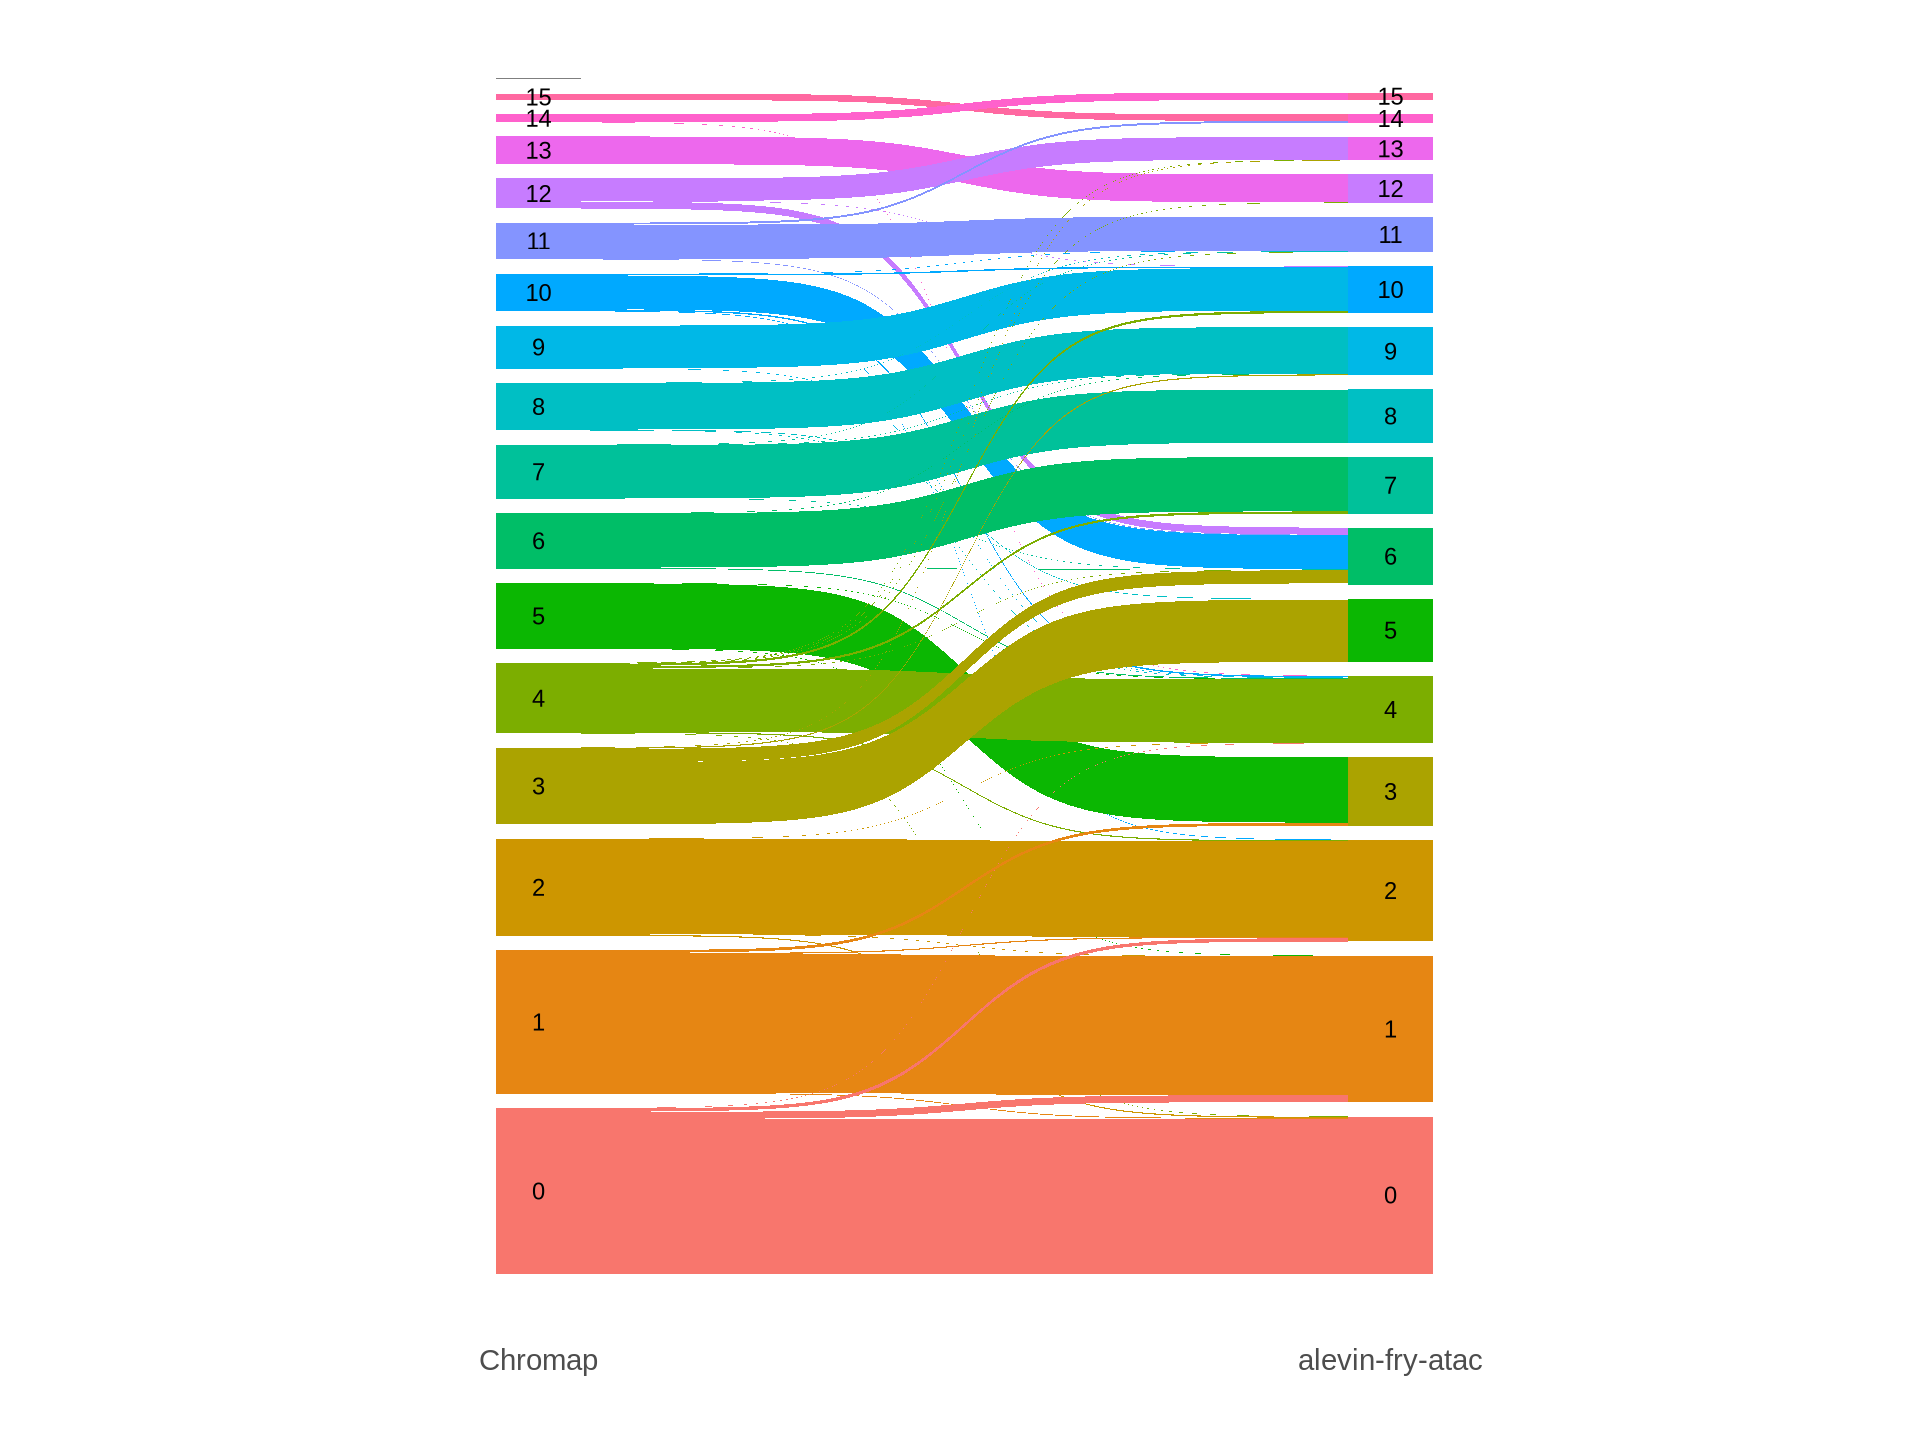

In [17]:
pChA <- make_long (
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode"),
    Chromap_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = size) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = fs, color = "black") +
        scale_x_discrete(breaks = c("Chromap_Cluster","Piscem_Cluster"),labels = c("Chromap","alevin-fry-atac"))
pChA

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”


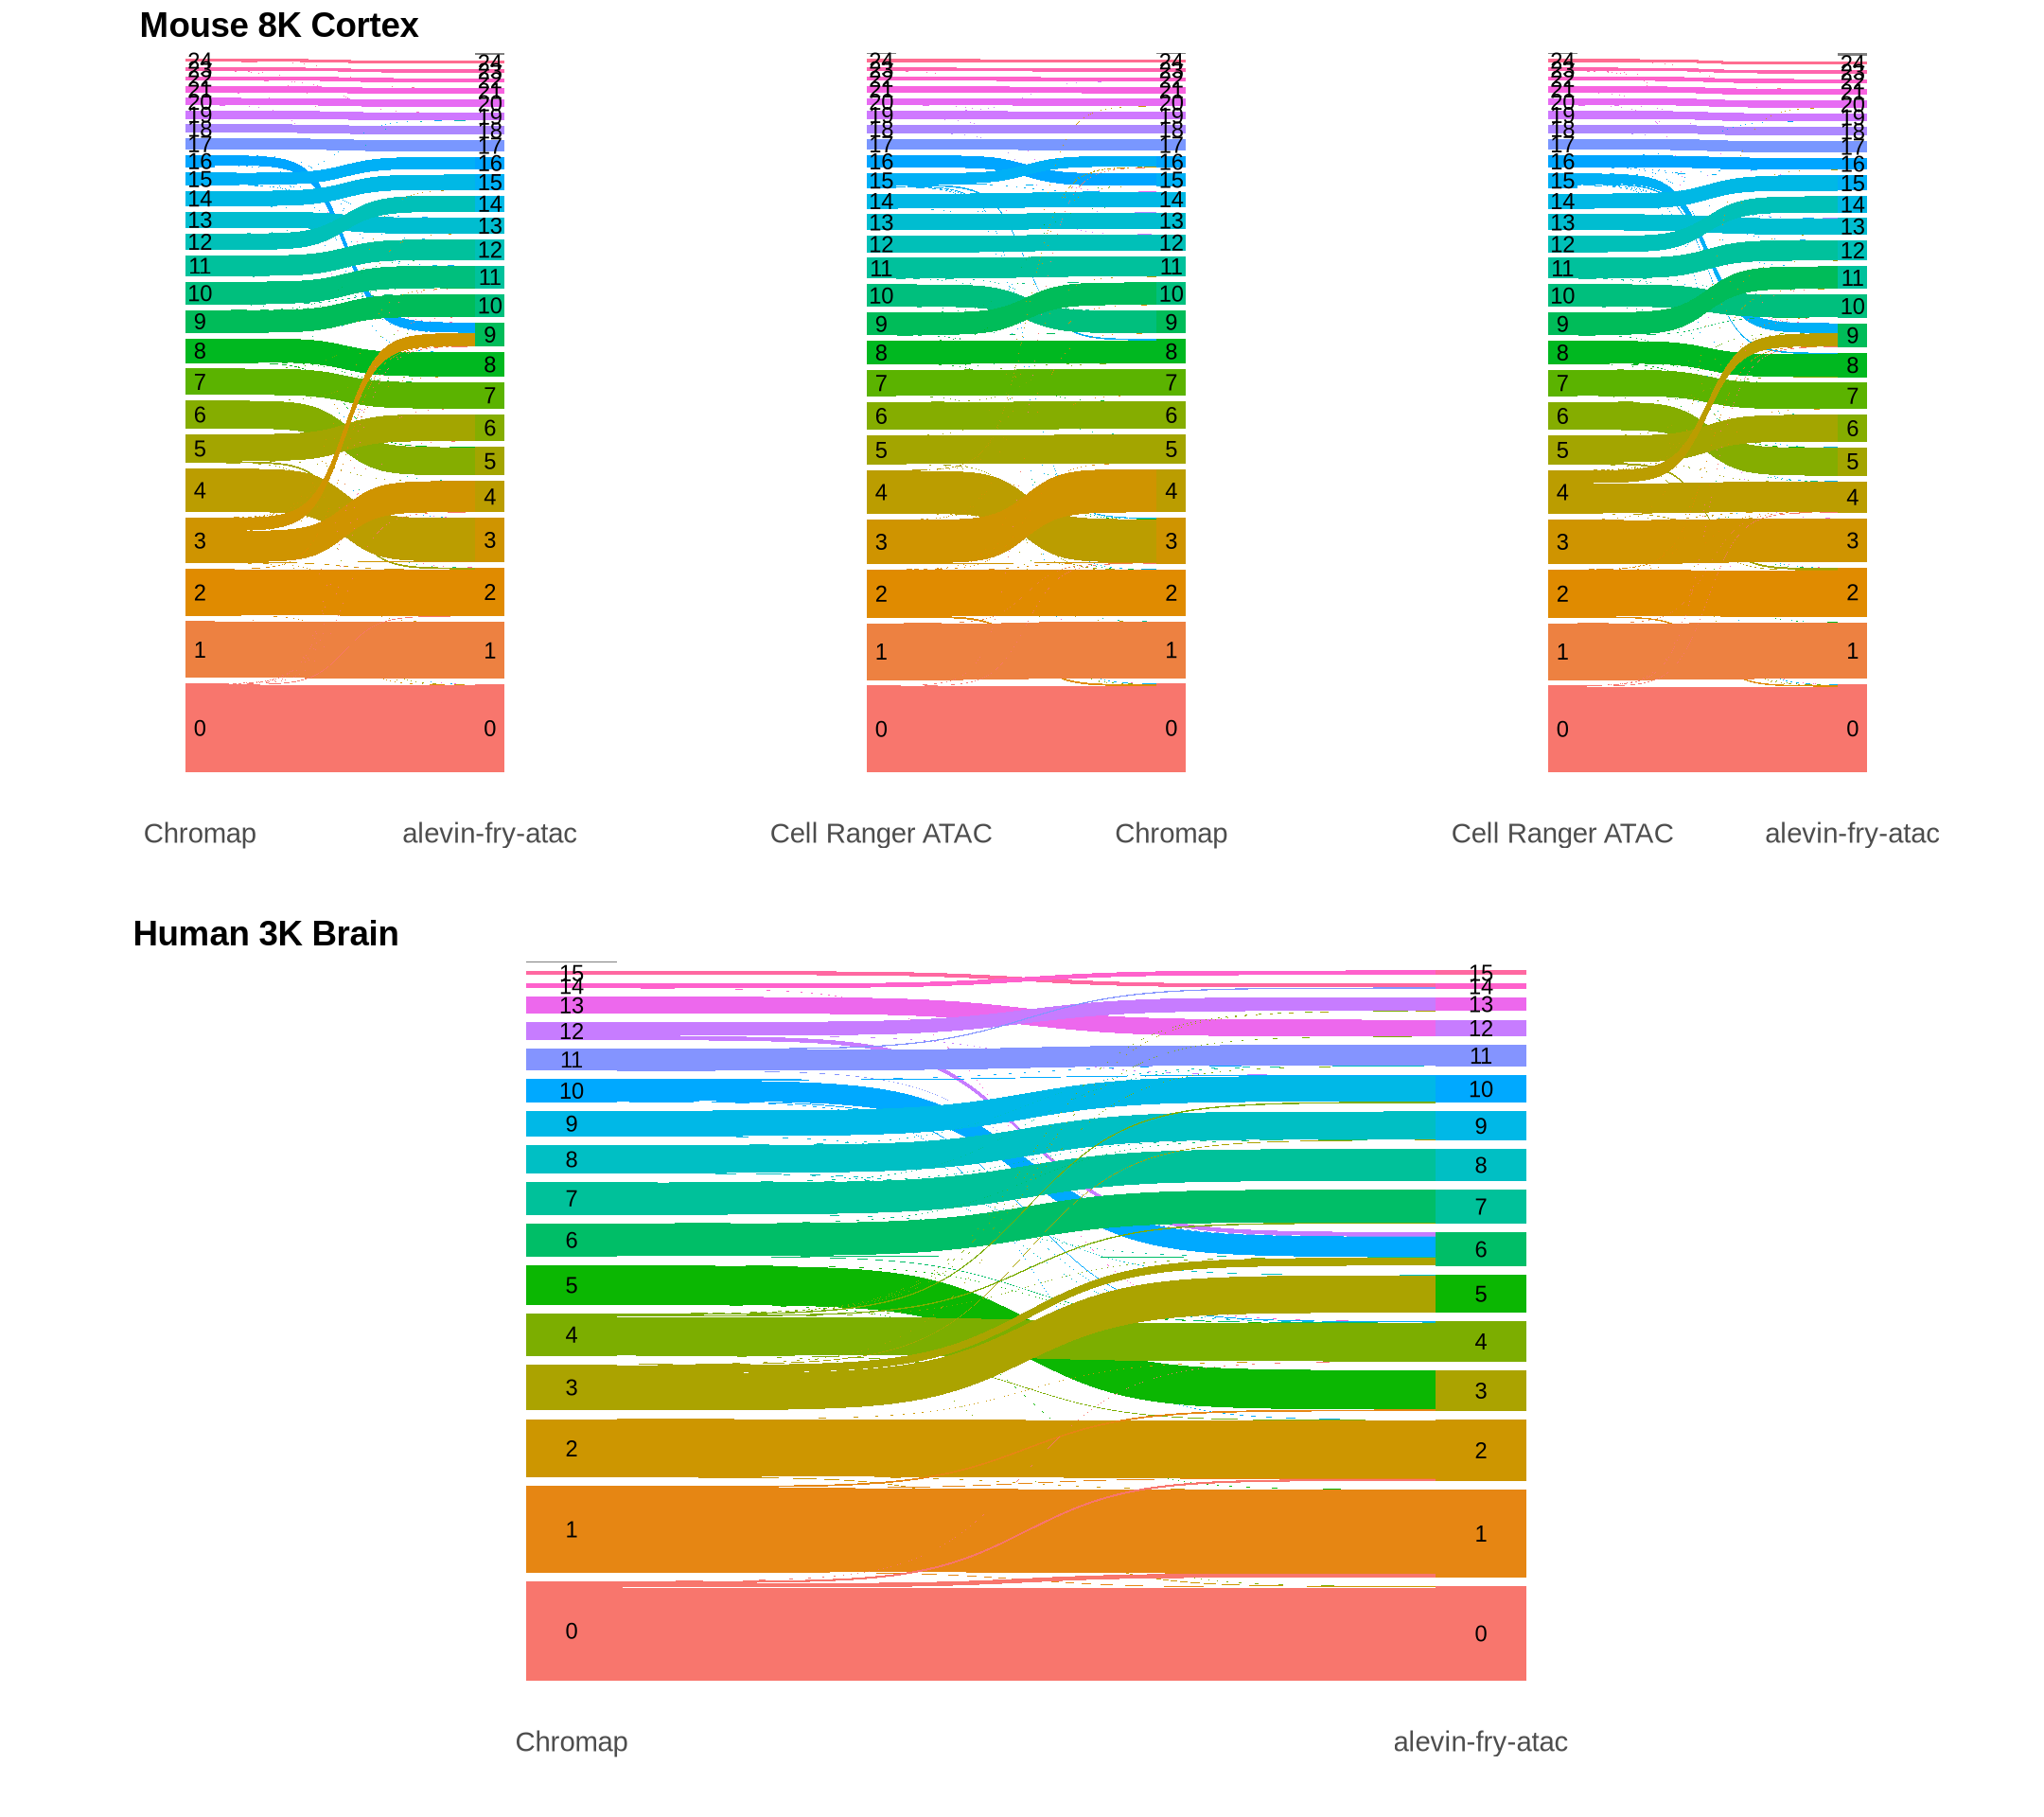

In [18]:
options(repr.plot.width=18, repr.plot.height=16)
ggarrange(p8k, pChA, nrow=2, labels = c("Mouse 8K Cortex", "Human 3K Brain"), font.label = list(size=size))

#### Cluster comparisons

In [80]:
int_cells <- intersect(clust_chromap_tbl$Barcode, clust_piscem_tbl$Barcode)
length(int_cells)
clust_chromap_tbl <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tbl <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode")

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 3448

[1] 0.8944344

[1] 0.9062278

#### UMAP

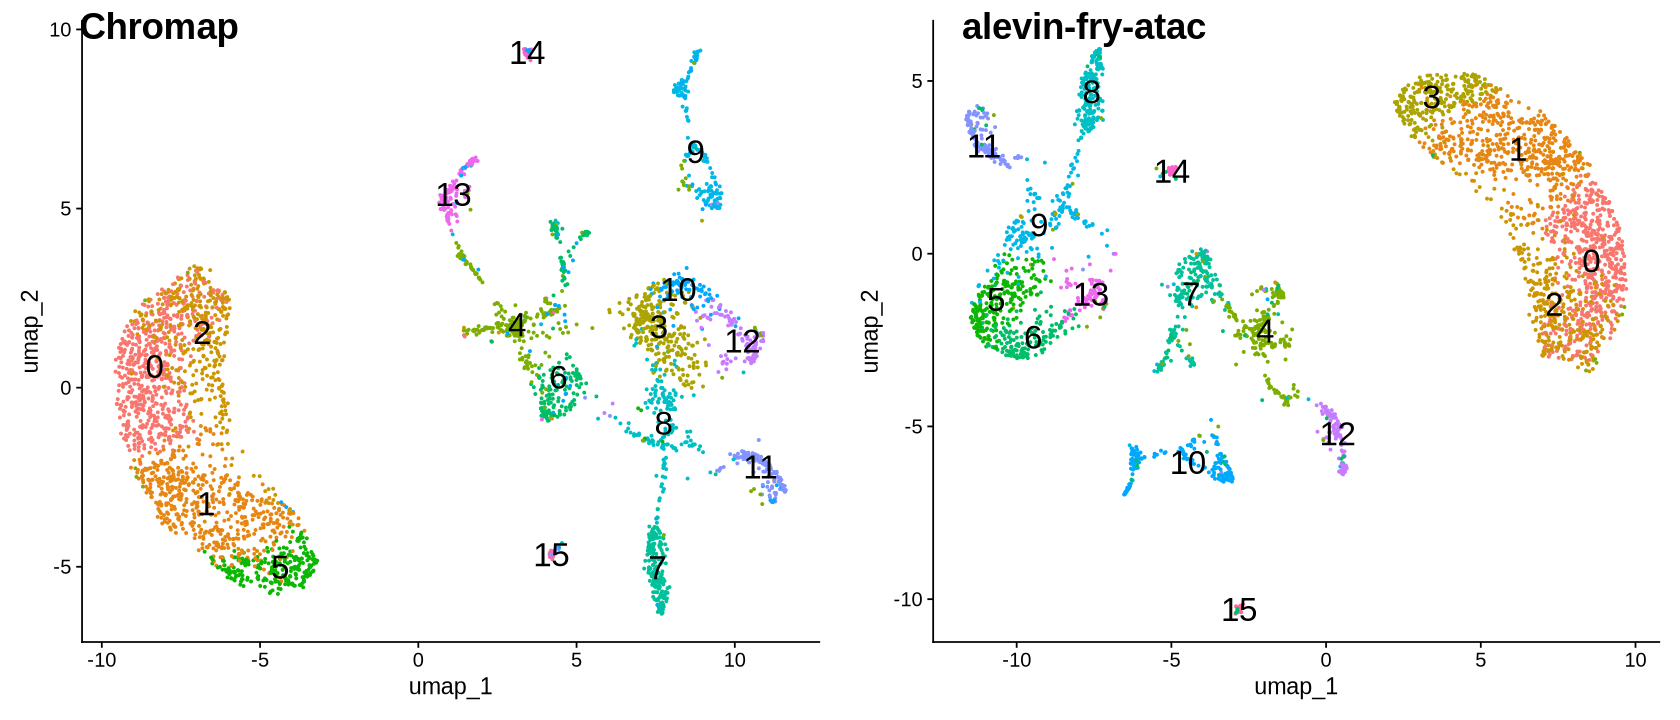

In [19]:
options(repr.plot.width=14, repr.plot.height=6)
pCh <- DimPlot(object = chromap_ob, label = TRUE, label.size = 7) + NoLegend()
pA <- DimPlot(object = piscem_ob, label = TRUE, label.size = 7) + NoLegend()
ggarrange(pCh, pA, labels = c("Chromap", "alevin-fry-atac"), font.label = list(size=size))

#### Peaks

In [82]:
chromapPeaks <- read.table(file.path(chromap_data_dir, "macs2_peaks.narrowPeak"))
chromapPeaks <- chromapPeaks[,c(1:3)]
colnames(chromapPeaks) <- c("chr","start","end")
chromapPeaksGr <- makeGRangesFromDataFrame(chromapPeaks)
chromapPeaksGr <- keepStandardChromosomes(chromapPeaksGr, pruning.mode="coarse")

piscemPeaks <- read.table(file.path(piscem_data_dir, "macs2_peaks.narrowPeak"))
piscemPeaks <- piscemPeaks[,c(1:3)]
colnames(piscemPeaks) <- c("chr","start","end")
piscemPeaksGr <- makeGRangesFromDataFrame(piscemPeaks)
piscemPeaksGr <- keepStandardChromosomes(piscemPeaksGr, pruning.mode="coarse")

In [83]:
summary(width(chromapPeaksGr))
summary(width(piscemPeaksGr))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  188.0   351.0   591.0   731.2   987.0  6135.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  181.0   339.0   573.0   710.2   958.0  5045.0 

In [84]:
length(chromapPeaksGr)
sum(width(chromapPeaksGr))/1e6
length(piscemPeaksGr)
sum(width(piscemPeaksGr))/1e6

[1] 152900

[1] 111.7935

[1] 162129

[1] 115.1435

In [85]:
common <- intersect_ranges(piscemPeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)
length(join_overlap_inner(chromapPeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 149529

[1] 106.7634

[1] 0.9779529

[1] 0.9222841